In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.1 MB/s eta 0:00:00


In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
pip install lightgbm

In [ ]:
pip install imbalanced-learn

In [ ]:
import lightgbm as lgb

In [ ]:
import pickle

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from yellowbrick.regressor import ResidualsPlot, PredictionError
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from yellowbrick.regressor import ResidualsPlot, PredictionError
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from catboost import CatBoostClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier, Pool
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek # Estas 3 últimas librerías sirven para generar datos sintéticos

In [ ]:
# 1. Carga del dataset
df = pd.read_csv('/content/balanced_credit_dataset.csv')

In [ ]:
# 2. Análisis Exploratorio de Datos (EDA)
print(df.head())

print(df.info())

print(df.describe())

   Flight    Time  Length  DayOfWeek  Airlineencoded  AirportFromencoded  \
0  5126.0  1150.0    60.0          7               6                  16   
1  2527.0  1298.0   114.0          6               5                  16   
2  2606.0  1134.0   102.0          4              17                 177   
3   532.0   810.0   203.0          1               4                 135   
4   108.0    30.0   202.0          5               2                  14   

   AirportToencoded  Class  
0                19      0  
1               104      0  
2                60      0  
3               159      0  
4               252      0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480362 entries, 0 to 480361
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Flight              480362 non-null  float64
 1   Time                480362 non-null  float64
 2   Length              480362 non-null  float64
 3   DayO

In [ ]:
# Verificar valores faltantes
print(df.isnull().sum())

Flight                0
Time                  0
Length                0
DayOfWeek             0
Airlineencoded        0
AirportFromencoded    0
AirportToencoded      0
Class                 0
dtype: int64


Codifico las variables categoricas

In [ ]:
# Con el fin de analizar la correlación entre las caracteristicas se realiza encode de las columnas categoricas
label_encoders = {}
columns_to_encode = ['Airline','AirportFrom','AirportTo']

for column in columns_to_encode:
    le = LabelEncoder()
    df[column + 'encoded'] = le.fit_transform(df[column])
    label_encoders[column] = le

df.tail()
#Codificacion con One Hot encoder que se experimento y que no dio resultados positivos, por lo cual no se utilizo en el proyecto definitivo
#Label encoder :Codificación de variables categóricas
#df = pd.get_dummies(df, columns=['Airline', 'AirportFrom', 'AirportTo'], drop_first=True)
#df.tail()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class,Airlineencoded,AirportFromencoded,AirportToencoded
539294,2419.0,866.0,189.0,DL,LGA,MSP,3,1,5,159,197
539295,5358.0,785.0,125.0,EV,ATL,SYR,4,1,6,16,273
539296,1587.0,500.0,65.0,WN,DAL,SAT,4,1,15,75,244
539297,1185.0,995.0,200.0,WN,DEN,BWI,4,1,15,79,45
539298,4003.0,815.0,101.0,9E,MEM,OKC,4,1,0,177,204


In [ ]:
# Verificar duplicados
print(df.duplicated().sum())

#eliminacion de datos duplicados
#df_sin_duplicados = df.drop_duplicates()
#print(df_sin_duplicados.duplicated().sum())

216571


In [ ]:
df.columns

Index(['Flight', 'Time', 'Length', 'DayOfWeek', 'Airlineencoded',
       'AirportFromencoded', 'AirportToencoded', 'Class'],
      dtype='object')

In [ ]:
# Quitar columnas que no se van a utilizar
df = df.drop(columns=['Airline', 'AirportFrom', 'AirportTo'])
df.columns

Index(['Flight', 'Time', 'Length', 'DayOfWeek', 'Class', 'Airlineencoded',
       'AirportFromencoded', 'AirportToencoded'],
      dtype='object')

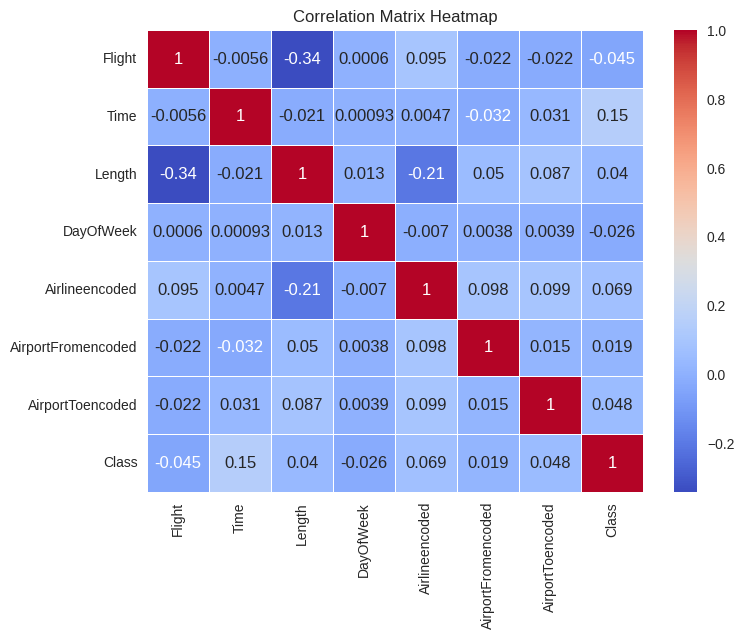

In [ ]:
#Correlación
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Balanceo de clase

In [ ]:
# Guardar una copia del dataset original para demostrar que no cambia
#data_original = df.copy()

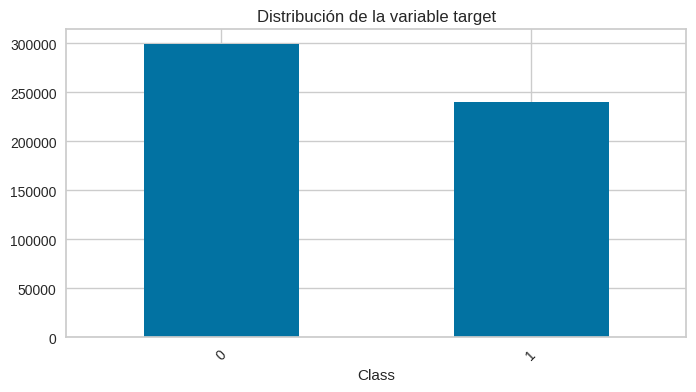

In [ ]:
# Paso 2: Análisis de la distribución de la variable target
plt.figure(figsize=(8, 4))
df["Class"].value_counts().plot(kind="bar", title="Distribución de la variable target")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Paso 3: Identificar si hay desbalance
class_distribution = df["Class"].value_counts()
print("Distribución de clases antes del balanceo:")
print(class_distribution)

Distribución de clases antes del balanceo:
Class
0    299118
1    299118
Name: count, dtype: int64


In [ ]:
# Separar características y variable objetivo
x = df.drop('Class', axis=1)
y = df['Class']

In [ ]:
# Opción 3: Combinación de SMOTE y Tomek links
smote = SMOTE(sampling_strategy='auto', random_state=42) # Amplifica el número de instancias
X_resampled, y_resampled = smote.fit_resample(x, y)
smote_tomek = SMOTETomek(random_state=42)
X_combined, y_combined = smote_tomek.fit_resample(x, y)
data_balanced = pd.DataFrame(X_resampled, columns=x.columns)
data_balanced["Class"] = y_resampled  # Agregar la variable objetivo balanceada reemplazando la anterior
print("Número de muestras después de SMOTE + Tomek:", len(y_combined))
print("Distribución después de SMOTE + Tomek:")
print(pd.Series(y_combined).value_counts())

Número de muestras después de SMOTE + Tomek: 594134
Distribución después de SMOTE + Tomek:
Class
0    297067
1    297067
Name: count, dtype: int64


In [ ]:
data_balanced = pd.DataFrame(X_resampled, columns=x.columns)
data_balanced["Class"] = y_resampled  # Agregar la variable objetivo balanceada reemplazando la anterior

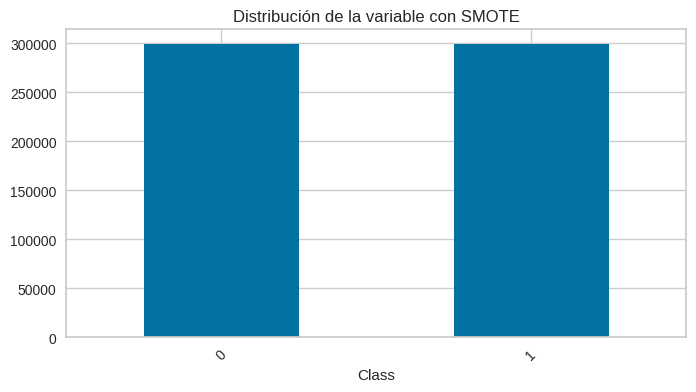

In [ ]:
plt.figure(figsize=(8, 4))
data_balanced["Class"].value_counts().plot(kind="bar", title="Distribución de la variable con SMOTE")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Opción 2: Submuestreo con RandomUnderSampler que no dio buenos resultados, por lo cual no es uso
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_under, y_under = undersampler.fit_resample(x, y)
data_balanced = pd.DataFrame(X_under, columns=x.columns)
data_balanced["Class"] = y_under  # Agregar la variable objetivo balanceada reemplazando la anterior
print("Número de muestras después de Submuestreo:", len(y_under))
print("Distribución después de Submuestreo:")
print(pd.Series(y_under).value_counts())

In [ ]:
data_balanced = pd.DataFrame(x_under, columns=x.columns)
data_balanced["Class"] = y_under  # Agregar la variable objetivo balanceada reemplazando la anterior

NameError: name 'x_under' is not defined

In [ ]:
#Balanceo de datos que no tuvo buenos resultados por lo cual no se uso
from imblearn.under_sampling import TomekLinks
from collections import Counter

# Crear el objeto TomekLinks
tomek = TomekLinks()

# Aplicar Tomek Links para eliminar ejemplos ruidosos
X_res, y_res = tomek.fit_resample(x, y)

# Mostrar la distribución de clases antes y después de aplicar Tomek Links
print('Distribución de clases antes de aplicar Tomek Links:', Counter(y))
print('Distribución de clases después de aplicar Tomek Links:', Counter(y_res))


Distribución de clases antes de aplicar Tomek Links: Counter({0: 299118, 1: 240181})
Distribución de clases después de aplicar Tomek Links: Counter({0: 297000, 1: 240181})


In [ ]:
data_balanced = pd.DataFrame(X_res, columns=x.columns)
data_balanced["Class"] = y_res  # Agregar la variable objetivo balanceada reemplazando la anterior

In [ ]:
plt.figure(figsize=(8, 4))
data_balanced["Class"].value_counts().plot(kind="bar", title="Distribución de la variable con Tomek")
plt.xticks(rotation=45)
plt.show()

NameError: name 'data_balanced' is not defined

<Figure size 800x400 with 0 Axes>

In [ ]:
# Guardar el dataset balanceado
data_balanced.to_csv("balanced_credit_dataset.csv", index=False)

print("Dataset balanceado guardado como 'balanced_credit_dataset.csv'")

Dataset balanceado guardado como 'balanced_credit_dataset.csv'


# Visualizacion de datos

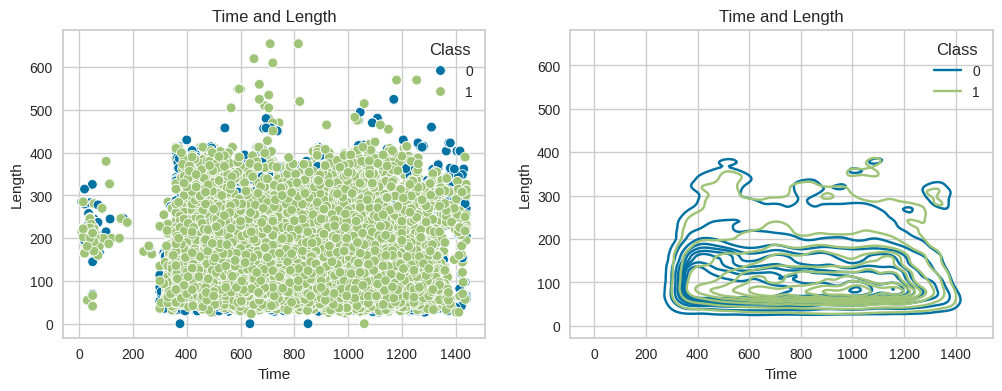

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Time and Length')
sns.scatterplot(x=df['Time'],y=df['Length'],hue=df['Class']);
plt.subplot(1,2,2)
plt.title('Time and Length')
sns.kdeplot(x=df['Time'],y=df['Length'],hue=df['Class']);

<Axes: xlabel='Time', ylabel='Class'>

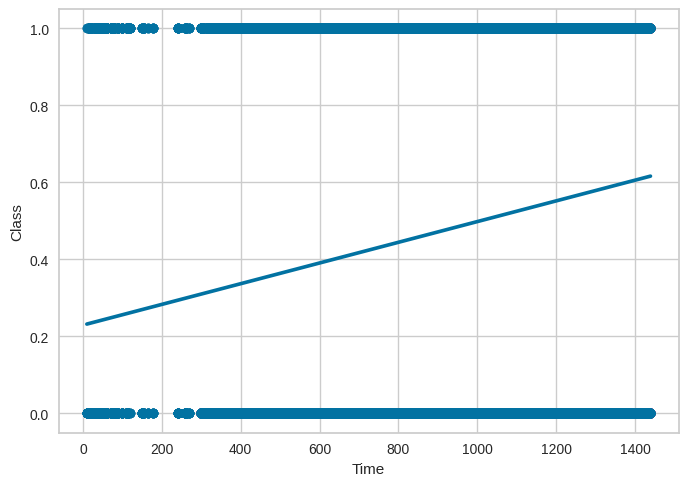

In [ ]:
# Checkear la correlación entre las caracteristicas independiente como (Tiempo) y la variable objetivo (Class)
sns.regplot(x = 'Time', y = 'Class', data=df, ci=None)

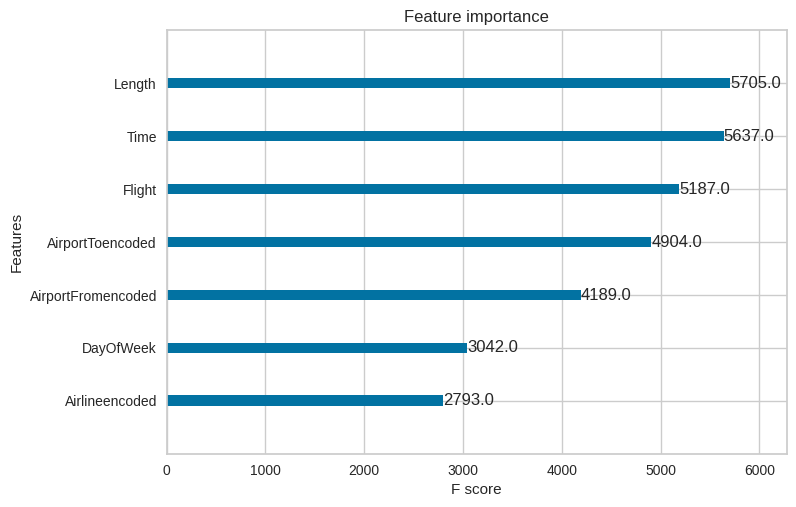

In [ ]:
import matplotlib.pyplot as plt

# Importancia de las características
xgb.plot_importance(model)
plt.show()

In [ ]:
# Separar características y variable objetivo
x = df.drop('Class', axis=1)
y = df['Class']
print(x)
print(y)


        Flight    Time  Length  DayOfWeek  Airlineencoded  AirportFromencoded  \
0       2313.0  1296.0   141.0          1               5                  16   
1       6948.0   360.0   146.0          4              12                  65   
2       1247.0  1170.0   143.0          3               3                  35   
3         31.0  1410.0   344.0          6              14                 203   
4        563.0   692.0    98.0          4               8                  32   
...        ...     ...     ...        ...             ...                 ...   
537176  2419.0   866.0   189.0          3               5                 159   
537177  5358.0   785.0   125.0          4               6                  16   
537178  1587.0   500.0    65.0          4              15                  75   
537179  1185.0   995.0   200.0          4              15                  79   
537180  4003.0   815.0   101.0          4               0                 177   

        AirportToencoded  


se divide el dataset en dos, una parte para entrenar y una pequeña parte para datos reales

In [ ]:
# División del dataset en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [ ]:
x_test.iloc[0]

,20920
Flight,392.0
Time,495.0
Length,120.0
DayOfWeek,3.0
Airlineencoded,1.0
AirportFromencoded,208.0
AirportToencoded,159.0


# Random Forest

In [ ]:
# 4. Entrenamiento de Modelos
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=4, min_samples_leaf=4,
                            criterion='entropy', random_state=42)
rf_model.fit(x_train, y_train)



RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=4,
                       min_samples_split=4, random_state=42)

In [ ]:
y_predict_rf =rf_model.predict(x_test)

The accuracy of RandomForestClassifier is 0.6670


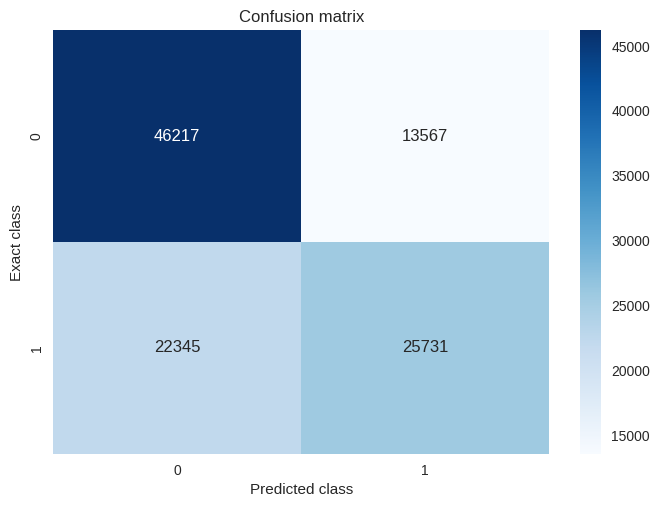

In [ ]:
accuracy = accuracy_score(y_test,y_predict_rf)
print('The accuracy of RandomForestClassifier is {:.4f}'.format(accuracy))

confus_matrix = confusion_matrix(y_test,y_predict_rf)
plt.title('Confusion matrix')
sns.heatmap(confus_matrix, annot=True, cmap='Blues', fmt='d')  # Formato entero
plt.xlabel('Predicted class')
plt.ylabel('Exact class');

serie = pd.Series(accuracy,index=['RandomForestClassifier'])
accuracy_RFmodel = pd.DataFrame({'accuracy':serie})

In [ ]:

# 5. Evaluación de Modelos
# Random Forest
y_pred_rf = rf_model.predict(x_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Random Forest Accuracy: 0.6683939556031024
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.69      0.67     59732
           1       0.68      0.65      0.66     59916

    accuracy                           0.67    119648
   macro avg       0.67      0.67      0.67    119648
weighted avg       0.67      0.67      0.67    119648

Random Forest Confusion Matrix:
 [[40938 18794]
 [20882 39034]]


# KNN

In [ ]:
# K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier(n_neighbors=10, weights='uniform', metric='minkowski', p=1, algorithm='ball_tree')
knn_model.fit(x_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=10, p=1)

# KNN escalado

The accuracy of KNeighborsClassifier is 0.6520
KNN Accuracy: 0.6519747821249768
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.80      0.72     59784
           1       0.65      0.47      0.55     48076

    accuracy                           0.65    107860
   macro avg       0.65      0.63      0.63    107860
weighted avg       0.65      0.65      0.64    107860

KNN Confusion Matrix:
 [[47618 12166]
 [25372 22704]]


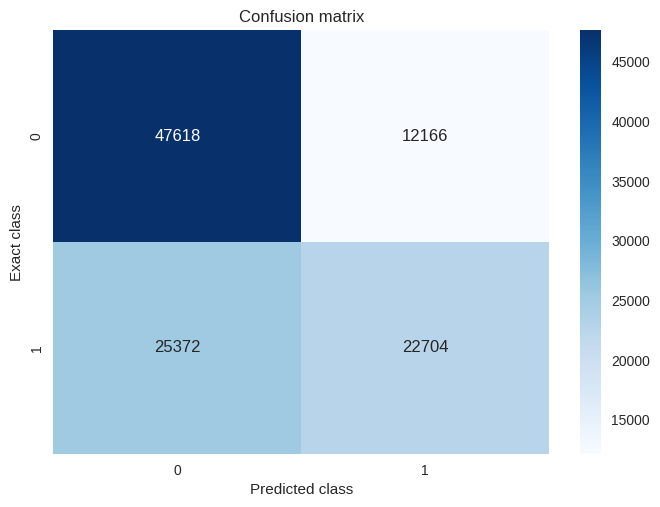

In [ ]:
#Escalado de datos para explorar esta posibilidad de que la precision mejore, dado que con la codificacion usada se podria presentar sesgos, despues de la experienci
# no se evidencio ninguna mejoria en la precision, por lo cual no se uso en el proyecto final

# K-Nearest Neighbors (KNN)
y_pred_knn = knn_model.predict(x_test)
accuracy = accuracy_score(y_test,y_pred_knn)
print('The accuracy of KNeighborsClassifier is {:.4f}'.format(accuracy))

confus_matrix = confusion_matrix(y_test,y_pred_knn)
plt.title('Confusion matrix')
sns.heatmap(confus_matrix, annot=True, cmap='Blues', fmt='d')  # Formato entero
plt.xlabel('Predicted class')
plt.ylabel('Exact class');

serie = pd.Series(accuracy,index=['KNeighborsClassifier'])
accuracy_KNmodel = pd.DataFrame({'accuracy':serie})
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))
print("KNN Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))

In [ ]:
# Escalado de características (importante para KNN)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier(n_neighbors=10, weights='uniform', metric='minkowski', p=1, algorithm='ball_tree')
knn_model.fit(x_train_scaled, y_train)

# K-Nearest Neighbors (KNN)
y_pred_knn = knn_model.predict(x_test_scaled)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))
print("KNN Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))

KNN Accuracy: 0.6459698448783097
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.72      0.67     59732
           1       0.67      0.57      0.62     59916

    accuracy                           0.65    119648
   macro avg       0.65      0.65      0.64    119648
weighted avg       0.65      0.65      0.64    119648

KNN Confusion Matrix:
 [[43118 16614]
 [25745 34171]]


# CatBoost

0:	learn: 0.6262299	test: 0.6265437	best: 0.6265437 (0)	total: 200ms	remaining: 6m 39s
100:	learn: 0.6518789	test: 0.6489431	best: 0.6489431 (100)	total: 22.3s	remaining: 6m 59s
200:	learn: 0.6581463	test: 0.6542370	best: 0.6542370 (200)	total: 32.9s	remaining: 4m 54s
300:	learn: 0.6622628	test: 0.6571482	best: 0.6571482 (300)	total: 42.7s	remaining: 4m
400:	learn: 0.6650766	test: 0.6595865	best: 0.6595865 (400)	total: 53.6s	remaining: 3m 33s
500:	learn: 0.6676402	test: 0.6609401	best: 0.6611163 (478)	total: 1m 4s	remaining: 3m 13s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6611162618
bestIteration = 478

Shrink model to first 479 iterations.
Precisión del modelo: 0.6611


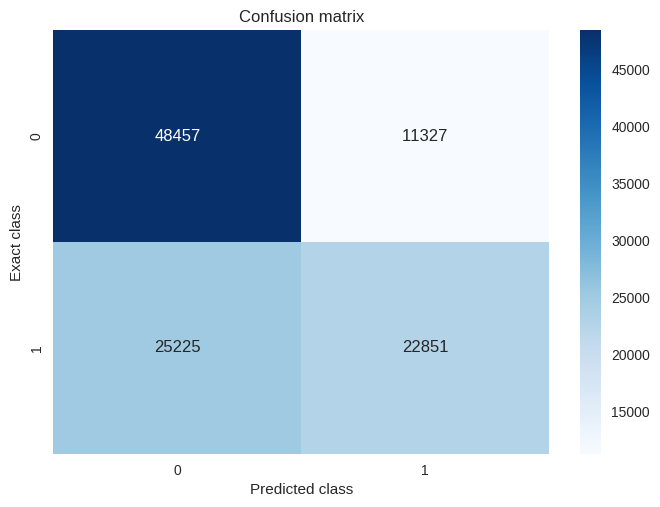

In [ ]:
# División de datos en conjuntos de entrenamiento y prueba
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definición y entrenamiento del modelo con regularización L2 ajustada
cb_model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=5,  # Coeficiente de regularización L2
    eval_metric='Accuracy',
    early_stopping_rounds=50,
    verbose=100
)

# Entrenamiento del modelo
cb_model.fit(x_train, y_train, eval_set=(x_test, y_test), use_best_model=True)

# Predicciones
y_pred_cb = cb_model.predict(x_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred_cb)
print(f'Precisión del modelo: {accuracy:.4f}')

serie = pd.Series(accuracy,index=['CatBoostClassifier'])
accuracy_CTmodel = pd.DataFrame({'accuracy':serie})

confus_matrix = confusion_matrix(y_test,y_pred_cb)
plt.title('Confusion matrix')
sns.heatmap(confus_matrix, annot=True, cmap='Blues', fmt='d')  # Formato entero
plt.xlabel('Predicted class')
plt.ylabel('Exact class');


# Regresion Logistica.

In [ ]:
rl_model = LogisticRegression(penalty='l2', C=10, solver='newton-cg', max_iter=200, fit_intercept=False, class_weight=None)
rl_model.fit(x_train, y_train)

LogisticRegression(C=10, fit_intercept=False, max_iter=200, solver='newton-cg')

Exactitud del modelo: 56.57%
                    accuracy
LogisticRegression  0.565715
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.58      0.75      0.66     59784
           1       0.52      0.33      0.40     48076

    accuracy                           0.57    107860
   macro avg       0.55      0.54      0.53    107860
weighted avg       0.56      0.57      0.55    107860



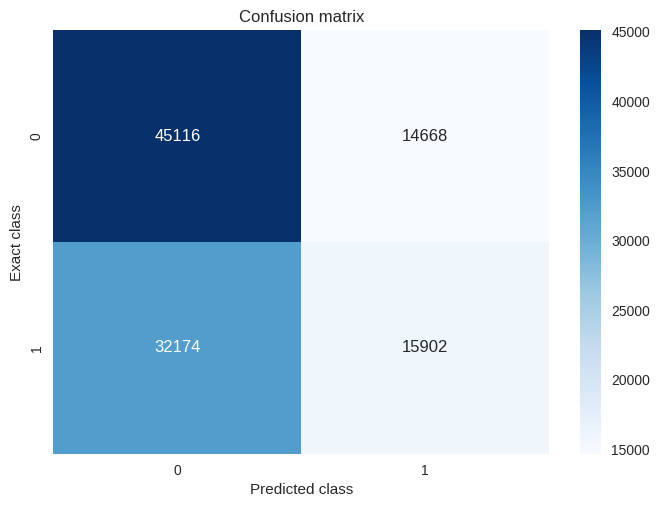

In [ ]:
y_pred_rl = rl_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred_rl)
print(f'Exactitud del modelo: {exactitud * 100:.2f}%')

#matriz_de_confusion = confusion_matrix(y_test, predicciones)
#print('Matriz de confusión:')
#print(matriz_de_confusion)

confus_matrix = confusion_matrix(y_test,y_pred_rl)
plt.title('Confusion matrix')
sns.heatmap(confus_matrix, annot=True, cmap='Blues', fmt='d')  # Formato entero
plt.xlabel('Predicted class')
plt.ylabel('Exact class')

serie = pd.Series(accuracy,index=['LogisticRegression'])
accuracy_Logmodel = pd.DataFrame({'accuracy':serie})
print(accuracy_Logmodel)

reporte = classification_report(y_test, y_pred_rl)
print('Reporte de clasificación:')
print(reporte)



# Gaussian Naive Bayes

In [ ]:
gnb_model = GaussianNB()
gnb_model.fit(x_train, y_train)


GaussianNB()

Mejores hiperparámetros: {'var_smoothing': 1e-08}
Accuracy: 0.5860838123493417


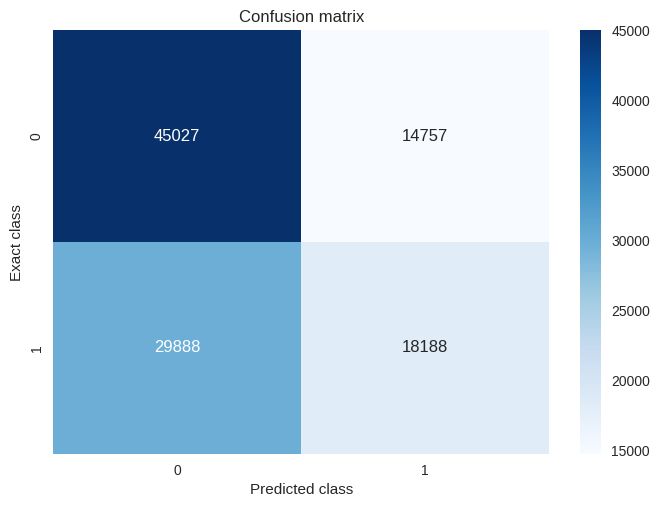

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define los hiperparámetros a probar
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

# Configura Grid Search con validación cruzada
grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Ajusta el modelo a los datos de entrenamiento
grid_search.fit(x_train, y_train)

# Encuentra los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Evalúa el modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_
y_pred_gnb = best_model.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred_gnb))

confus_matrix = confusion_matrix(y_test,y_pred_gnb)
plt.title('Confusion matrix')
sns.heatmap(confus_matrix, annot=True, cmap='Blues', fmt='d')  # Formato entero
plt.xlabel('Predicted class')
plt.ylabel('Exact class')
serie = pd.Series(accuracy,index=['GaussianNB'])
accuracy_NBmodel = pd.DataFrame({'accuracy':serie})

# Redes Neuronales

In [ ]:
input_dim = 7  # Número de características en tus datos de entrada
output_dim = 2  # Número de clases en tu problema de clasificación

# Suponiendo que 'x' son tus características y 'y' son tus etiquetas
#x = np.random.random((1000, 30))  # 1000 muestras, cada una con 30 características
#y = np.random.randint(2, size=(1000, 1))  # 1000 etiquetas de clase (0 o 1)

# Dividir los datos en conjuntos de entrenamiento y prueba
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Definir el input_dim basado en los datos
input_dim = x_train.shape[1]

# Definir el modelo
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(input_dim,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Para clasificación binaria

# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo con los datos de entrenamiento
history = model.fit(x_train, y_train, epochs=20,
                    validation_data=(x_test, y_test))

# Evaluar el modelo con datos de prueba
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'\nPrecisión del modelo: {test_acc}')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
13483/13483 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.5230 - loss: 2.8353 - val_accuracy: 0.5473 - val_loss: 0.7369
Epoch 2/20
13483/13483 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.5420 - loss: 0.9112 - val_accuracy: 0.5713 - val_loss: 0.6779
Epoch 3/20
13483/13483 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.5761 - loss: 0.6795 - val_accuracy: 0.5721 - val_loss: 0.6768
Epoch 4/20
13483/13483 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.5842 - loss: 0.6742 - val_accuracy: 0.5737 - val_loss: 0.6768
Epoch 5/20
13483/13483 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.5845 - loss: 0.6713 - val_accuracy: 0.5857 - val_loss: 0.6705
Epoch 6/20
13483/13483 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - accuracy: 0.5893 - loss: 0.6688 - val_accuracy: 0.5887 - val_loss: 0.6667
Epoch 7/20
13483/13483 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.5877 - loss: 0.6687 - val_accuracy: 0.5889 - val_loss: 0.6674
Epoch 8/20
13483/13483 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 

# LightGBM

[LightGBM] [Info] Number of positive: 192105, number of negative: 239334
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1166
[LightGBM] [Info] Number of data points in the train set: 431439, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445266 -> initscore=-0.219818
[LightGBM] [Info] Start training from score -0.219818
Accuracy: 66.39%


Text(70.72222222222221, 0.5, 'Exact class')

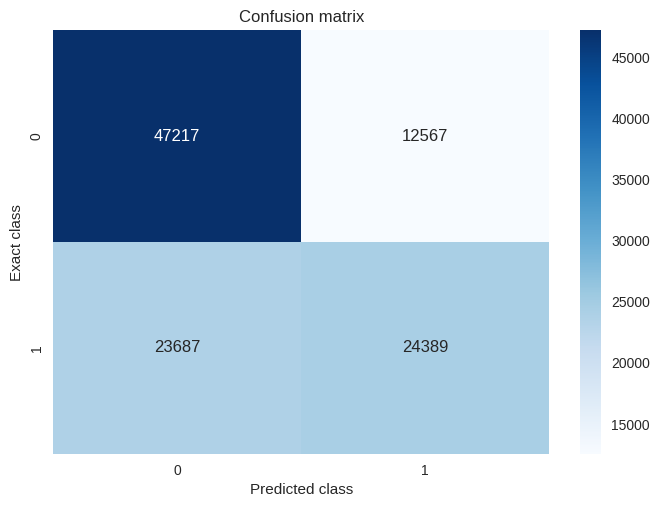

In [ ]:
# Crear el modelo
lgb_model = lgb.LGBMClassifier(boosting_type = 'dart', metric= 'L2', objective = 'binary',n_estimators=200, learning_rate=1, max_depth=6)

# Entrenar el modelo
lgb_model.fit(x_train, y_train)

# Hacer predicciones
y_pred_lgb = lgb_model.predict(x_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred_lgb)
print(f"Accuracy: {accuracy * 100:.2f}%")
serie = pd.Series(accuracy,index=['LGBMClassifier'])
accuracy_LGBMmodel = pd.DataFrame({'accuracy':serie})

confus_matrix = confusion_matrix(y_test,y_pred_lgb)
plt.title('Confusion matrix')
sns.heatmap(confus_matrix, annot=True, cmap='Blues', fmt='d')  # Formato entero
plt.xlabel('Predicted class')
plt.ylabel('Exact class')


# Comparación del rendimiento de cada uno de los algoritmos utilizados

In [ ]:
accuracy_models = pd.concat([accuracy_RFmodel,accuracy_KNmodel,accuracy_CTmodel,accuracy_Logmodel,accuracy_XGBmodel,accuracy_NBmodel,accuracy_LGBMmodel ])
accuracy_models

,accuracy
RandomForestClassifier,0.667050
KNeighborsClassifier,0.651975
CatBoostClassifier,0.661116
LogisticRegression,0.565715
XGB,0.670007
GaussianNB,0.565715
LGBMClassifier,0.663879
